# Libraries

In [189]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import f_regression, chi2, f_classif, SelectKBest, SelectPercentile, VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.decomposition import PCA,KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.cluster import KMeans

# Custom Functions

In [121]:
#calculate adjusted r2
def m_adjusted_r2(obs_num, var_num,r2):
    return (1-(1-r2)*((obs_num-1)/(obs_num-var_num-1)))

#show features regression in Dataframe
def m_fregression(x,y):
    features_regression = pd.DataFrame(columns=['feature','coefficient','pval'])
    for i in range (x.shape[1]):
        df_f_regression = f_regression(x,y)
        row = {'feature':x.columns[i],'coefficient':df_f_regression[0][i].round(2),'pval':df_f_regression[1][i].round(5)}
        features_regression = features_regression.append(row,ignore_index=True)
    return (features_regression)

#calculating multicolinearity between variables
def m_VIF(x,y):
    #get columns names
    a = x.columns
    b = y.columns
    
    #loop to generate a (specially-formated) string containing (dependant variable) and (independent variables)
    string_fun = '{}~'.format(b[0])
    for i in range(0,len(a),1):
        string_fun = string_fun+"{}+".format(a[i])
        
    #to drop the last (+)
    string_fun= string_fun[0:len(string_fun)-1]
    string_fun
    
    #generate a full dataframe containing dependent and independent variables
    df_vif_gen = pd.merge(left=y,right=x,left_index=True,right_index=True)
    
    
    #find design matrix for regression model using 'rating' as response variable 
    y,x = dmatrices(string_fun, data=df_vif_gen, return_type='dataframe')

    #create DataFrame to hold VIF values
    vif_df = pd.DataFrame()
    vif_df['variable'] = x.columns 

    #calculate VIF for each predictor variable 
    vif_df['VIF'] = np.round([variance_inflation_factor(x.values, i) for i in range(x.shape[1])],2)

    #view VIF for each predictor variable 
    print ('VIF=1: There is no correlation between a given predictor variable and any other predictor variables in the model.\n')
    print ('VIF=(1-5): There is moderate correlation between a given predictor variable and other predictor variables in the model.\n')
    print ('VIF>5: There is severe correlation between a given predictor variable and other predictor variables in the model.')

    return vif_df

# find correlated features
def m_correlation(dataset, threshold):
    col_corr = []  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.append(colname)
                col_corr = list(set(col_corr))
    return col_corr

#reduce dataframe by quantile value (outlier), return the reduced dataframe and print the curve
def m_df_trim (dataframe,column_name,q_low,q_high):   
    q_low = dataframe[column_name].quantile(q=q_low)
    q_high = dataframe[column_name].quantile(q=q_high)

    df_reduced = dataframe[(dataframe[column_name]>q_low)&(dataframe[column_name]<=q_high)]
    print (np.round(100-df_reduced.shape[0]/dataframe.shape[0]*100,2),"% of data will be lost")
    fig, ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2);
    sns.histplot(data=dataframe,x=column_name,ax=ax[0],label='Original');
    sns.histplot(data=df_reduced,x=column_name,ax=ax[1],label='Reduced')
    ax[0].legend()
    ax[1].legend()
    return df_reduced

#creating different linear regression models and a dataframe containing the summary info
def m_mlinear_regression(xtr,xts,ytr,yts):
#create a dataframe for modeling summary 
    models_summary = pd.DataFrame(columns=['Model','Type','Scaled','Score'])

    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Linear'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='SVR'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='Random forest'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='XGBoost'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #GradientBoosting   
    model = GradientBoostingRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='GradientBoosting'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)
    
#---------------SCALING-------------------#
    sc    = StandardScaler()              #
    xtr_sc= sc.fit_transform(xtr)         #
    xts_sc= sc.transform(xts)             #
#-----------------------------------------#
    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Linear'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='SVR'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='Random forest'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='XGBoost'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #GradientBoosting   
    model = GradientBoostingRegressor()
    model.fit(xtr_sc,ytr)
    
    model_summary = models_summary.sort_values(by='Score',ascending=False)
    model_summary.reset_index(inplace=True)
    return model_summary

#return a list and graph of how features importance to target value
def m_feature_importance (xtrain,ytrain,n_estimators):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(xtrain,ytrain)
    df_features_importance = pd.DataFrame({'features':xtrain.columns,'importance':rf.feature_importances_})
    df_features_importance.sort_values(by='importance',axis=0,inplace=True,ascending=False)
    sns.barplot(x=df_features_importance['importance'],
                y=df_features_importance['features'],
                color='b')  
    return df_features_importance

#split dataframe into target variable and features
def m_xy_split(df,target_column):
    col = (df.columns).drop(target_column)
    y = df[[target_column]]
    x = df[col]
    return x,y

# Importing data

In [122]:
df_raw = pd.read_csv('data.csv')

In [123]:
df_raw.head(2)

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98
1,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14


**Input features in order:**
1) CRIM: per capita crime rate by town. <br>
2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.<br>
3) INDUS: proportion of non-retail business acres per town<br>
4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)<br>
5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]<br>
6) RM: average number of rooms per dwelling<br>
7) AGE: proportion of owner-occupied units built prior to 1940<br>
8) DIS: weighted distances to five Boston employment centres<br>
9) RAD: index of accessibility to radial highways<br>
10) TAX: full-value property-tax rate per $10,000 [$/10k]<br>
11) PTRATIO: pupil-teacher ratio by town<br>
12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town<br>
13) LSTAT: % lower status of the population<br>

**Output variable:**
1) MEDV: Median value of owner-occupied homes in $1000's [k$]

**Problem Description:**<br>
model the value of owner occupied homes related to different features.

In [124]:
#let's check basic dataframe info
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MEDV     506 non-null    float64
 1   CRIM     506 non-null    float64
 2   ZN       506 non-null    float64
 3   INDUS    506 non-null    float64
 4   CHAS     506 non-null    int64  
 5   NOX      506 non-null    float64
 6   RM       506 non-null    float64
 7   AGE      506 non-null    float64
 8   DIS      506 non-null    float64
 9   RAD      506 non-null    int64  
 10  TAX      506 non-null    int64  
 11  PTRATIO  506 non-null    float64
 12  B        506 non-null    float64
 13  LSTAT    506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


* we have 1 target variable [MEDV] and 13 different features. <br>
* all columns are in number format
* there aren't any null values

In [125]:
#extract columns
col_raw = list(df_raw.columns)
col_raw

['MEDV',
 'CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

# Exploratory Data Analysis

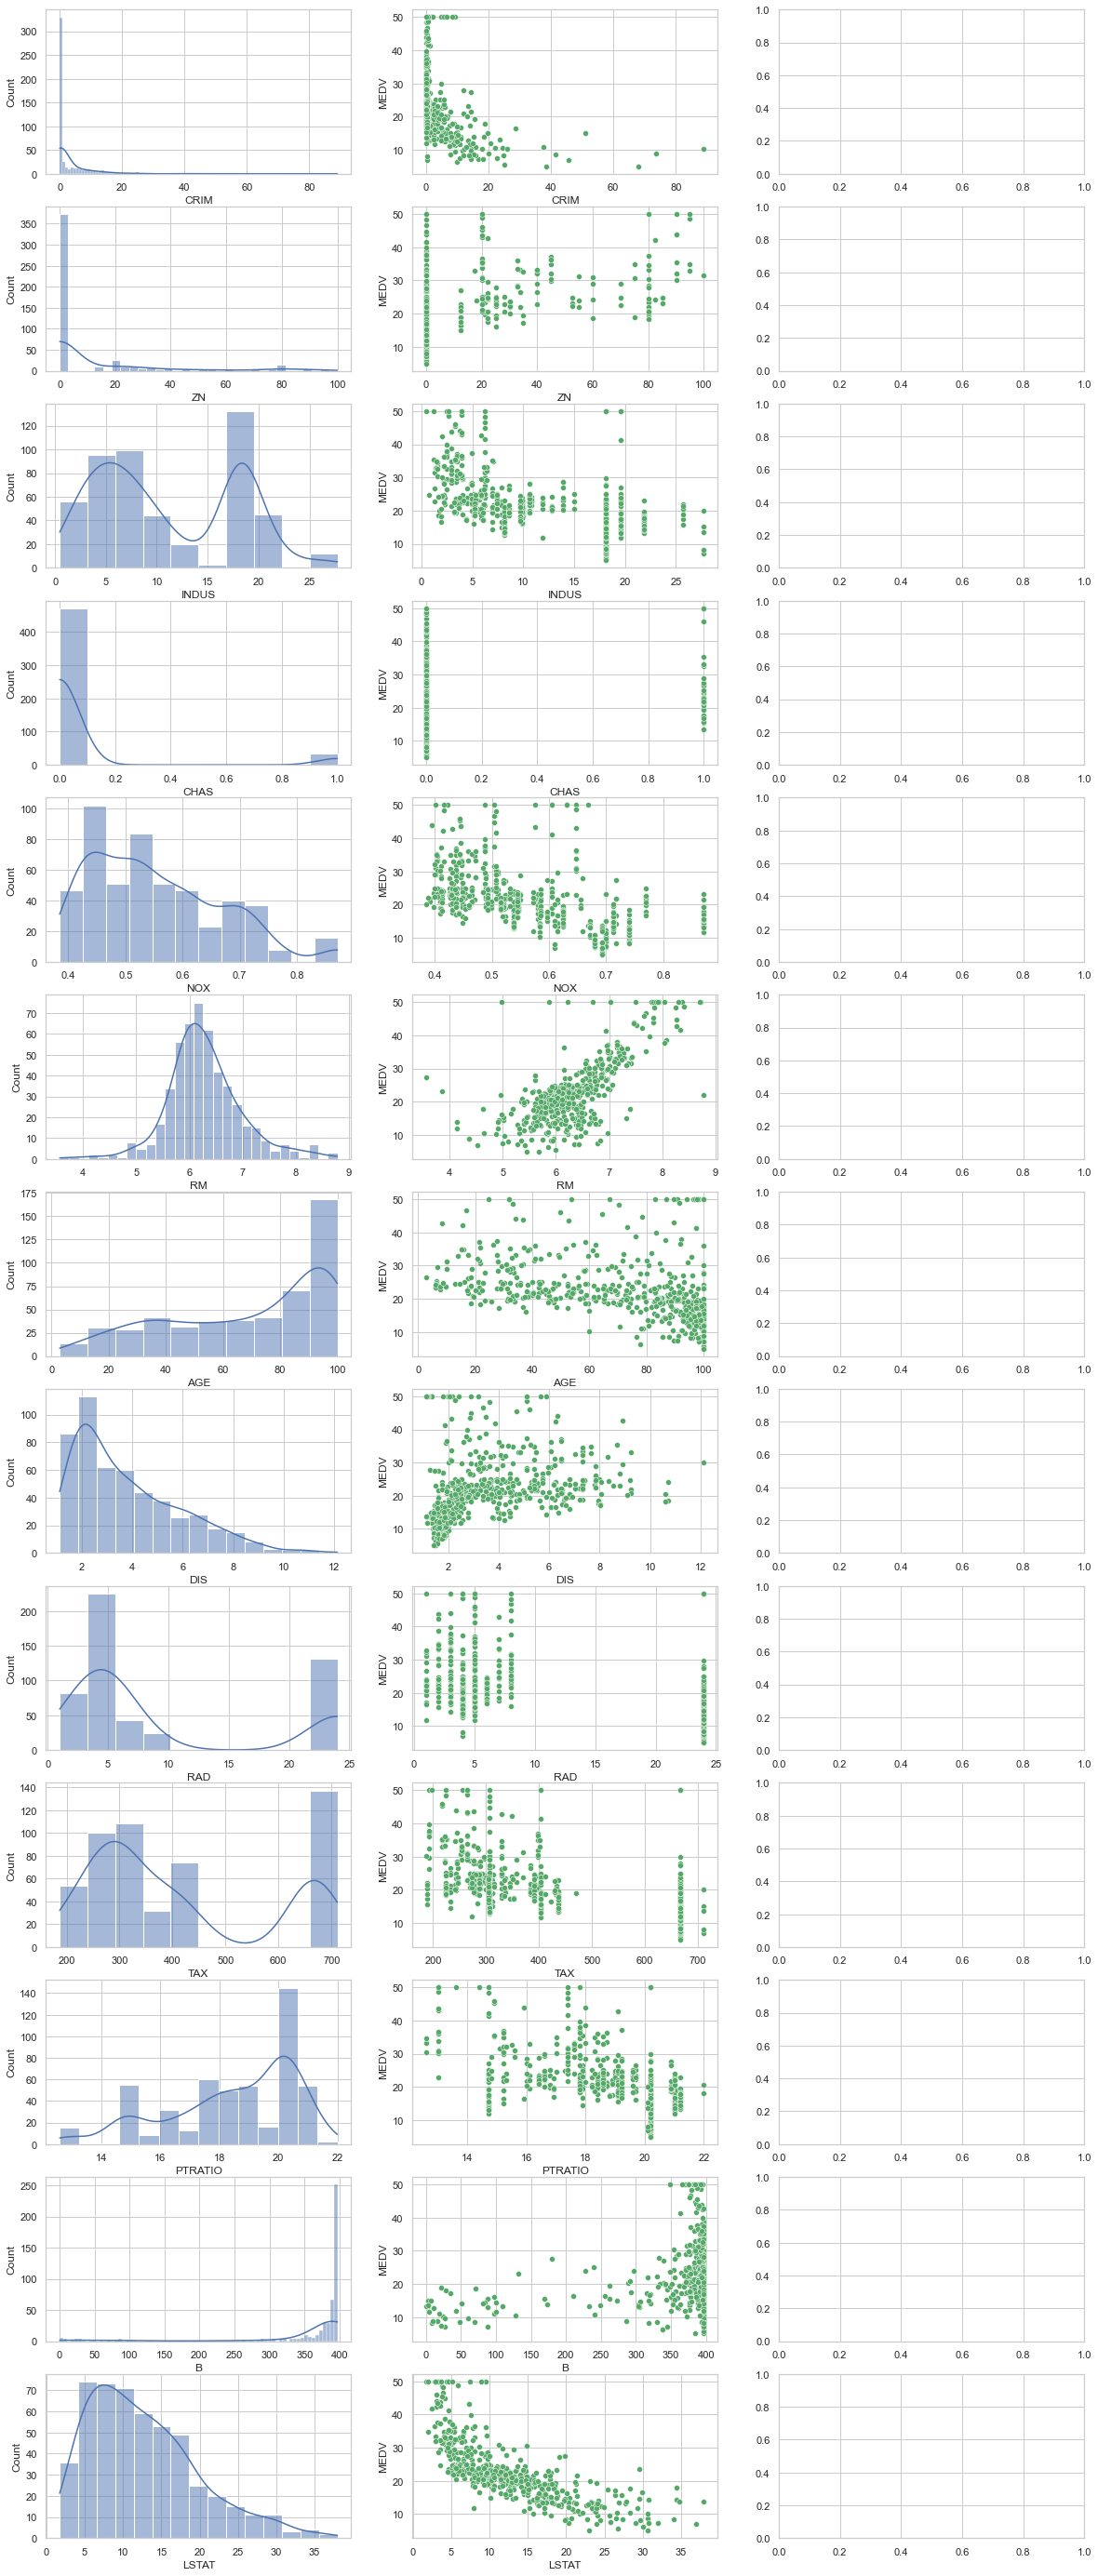

In [126]:
#let's draw all features against target variable and transforming features if needed
fig,ax = plt.subplots(nrows=(len(col_raw)-1),ncols=3,figsize=(20,50));
for i in range (1,len(col_raw),1):
    sns.histplot(data=df_raw.iloc[:,i],kde=True,ax=ax[i-1,0])
    sns.scatterplot(data=df_raw,x=col_raw[i],y=col_raw[0],ax=ax[i-1,1],color='g');

#drawing the final features transformations
#ax[0,2].scatter(np.log(df_raw['CRIM']),df_raw['MEDV'],color='r');
#ax[1,2].scatter(np.log(df_raw['ZN']),df_raw['MEDV'],color='r');
#ax[3,2].scatter(np.log(df_raw['CHAS']),df_raw['MEDV'],color='r');
#ax[7,2].scatter(np.log(df_raw['DIS']),df_raw['MEDV'],color='r');
#ax[12,2].scatter(np.log(df_raw['LSTAT']),df_raw['MEDV'],color='r');

from basic distribution we can notice the following about features:<br>
* CRIM: it may contain outliers - there is negative correlation but not strong against target variable
* ZN: most of values are 0 - there is almost constat relation to target value
* IDUS: values are scattered in double normal distribution curve - there is no obvious correlation against target variable
* CHAS: most of values are 0
* **NOX:** values are skewed to right, there is obvious negative correlation against target variable
* **RM:** values are perfectly distributed normally, there is strong positive correlation against target variable
* AGE: values are skewed to left, there isn't obvious correlation against target variable
* DIS: values are skewed to right, there isn't clear correlation against target variable
* RAD: the graph of values and relation to target cannot give us any clear information
* TAX: the graph of values and relation to target cannot give us any clear information
* PTRATIO: the graph of values and relation to target cannot give us any clear information
* B: values are skewed to left, It may contain outliers, there is not clear information about correlation to target variable
* **LSTAT:** values are skewed to right, there is strong negative correlation to target variable



# Modeling raw data

before doing any preprocessing to data, i will model raw data by different models and check if I can improve our model by doing some feature engineering

In [127]:
y_raw = df_raw[col_raw[0:1]]
x_raw = df_raw[col_raw[1:]]

In [128]:
x_rw_tr, x_rw_ts, y_rw_tr, y_rw_ts = train_test_split(x_raw,y_raw, train_size=0.8,shuffle=True)

In [129]:
m_mlinear_regression(x_rw_tr,x_rw_ts,y_rw_tr,y_rw_ts)

,index,Model,Type,Scaled,Score
0,12,GradientBoosting,500,No,0.897063
1,24,XGBoost,500,Yes,0.883670
2,11,XGBoost,500,No,0.882928
3,20,Random forest,200,Yes,0.871249
4,9,Random forest,400,No,0.869717
5,10,Random forest,500,No,0.869101
6,23,Random forest,500,Yes,0.868376
7,21,Random forest,300,Yes,0.866589
8,22,Random forest,400,Yes,0.864300
9,19,Random forest,100,Yes,0.863971


* by modeling raw data, we got initial score [70% to 79%]
* best performing models are: Gradientboosting / XGBoost / Random forest <br>
I will do some feature engineering to check if I can improve model accuracy

# Feature Engineering

In [130]:
#getting a copy of initial dataframe
df = df_raw.copy()
col = col_raw

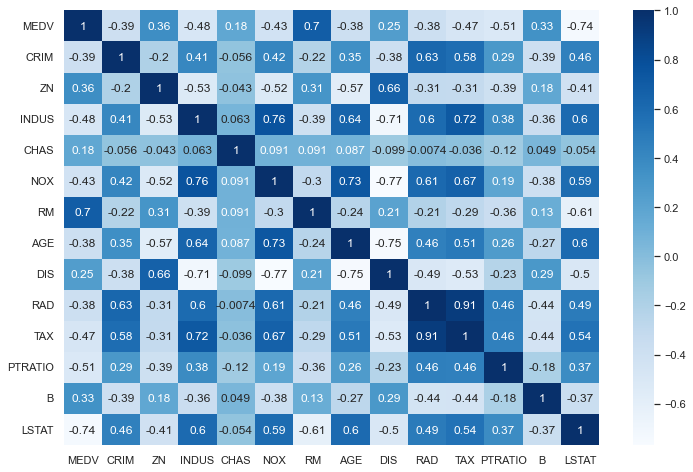

In [131]:
#drawing a correlation map
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),cmap='Blues',annot=True,fmt='0.2g');

As I expected by visualizations before: RM, NOX and LSTAT are strongly correlated with target variable <br>. 
let's discover the important features to predict our target variable: 

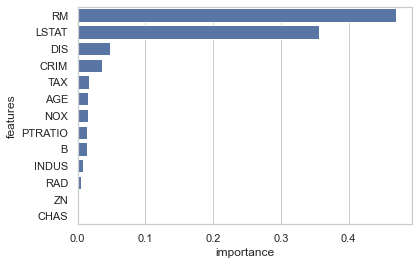

In [132]:
m_feature_importance(x_rw_tr,y_rw_tr,100);

Again, **[RM, LSTAT, DIS]** are important features to predict target variable, but **[CRIM,NOX, PTRATIO, AGE, B, TAX]** do participate to our model. However, **[RAD, CHAS and ZN]** are not important. <br>
I will search for any multicolinearity between features

In [133]:
#using heatmap
m_correlation(df,0.75)

['TAX', 'NOX', 'DIS']

In [134]:
m_VIF(x_raw,y_raw)

VIF=1: There is no correlation between a given predictor variable and any other predictor variables in the model.

VIF=(1-5): There is moderate correlation between a given predictor variable and other predictor variables in the model.

VIF>5: There is severe correlation between a given predictor variable and other predictor variables in the model.


,variable,VIF
0,Intercept,585.27
1,CRIM,1.79
2,ZN,2.30
3,INDUS,3.99
4,CHAS,1.07
5,NOX,4.39
6,RM,1.93
7,AGE,3.10
8,DIS,3.96
9,RAD,7.48


so RAD & TAX are heavily correlated with each others, I will drop RAD since it's not important to predict our target variable. <br>
NOX & DIS are correlated, I will drop NOX since it's not from top features which predict our variable

In [135]:
col_cut = ['MEDV','CRIM', 'ZN', 'INDUS', 'CHAS','RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df_cut= df[col_cut]

In [136]:
x_cut,y_cut = m_xy_split(df_cut,'MEDV')

In [137]:
x_cut_tr,x_cut_ts,y_cut_tr,y_cut_ts = train_test_split(x_cut,y_cut,train_size=0.8)

In [138]:
m_mlinear_regression(x_cut_tr,x_cut_ts,y_cut_tr,y_cut_ts)

,index,Model,Type,Scaled,Score
0,11,XGBoost,500,No,0.906859
1,24,XGBoost,500,Yes,0.906530
2,12,GradientBoosting,500,No,0.898331
3,10,Random forest,500,No,0.876603
4,20,Random forest,200,Yes,0.875568
5,23,Random forest,500,Yes,0.875157
6,19,Random forest,100,Yes,0.874818
7,9,Random forest,400,No,0.874366
8,7,Random forest,200,No,0.873743
9,8,Random forest,300,No,0.873557


Dropping [NOX and RAD] didn't improve our model and also didn't affect it badly, I will continue in feature engineering <br>
**let's drop ZN and CHAS because they are not important in predicting our model**

In [139]:
col_cut_2 = ['MEDV','CRIM', 'INDUS','RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df_cut_2= df[col_cut_2]

In [140]:
x_cut_2,y_cut_2 = m_xy_split(df_cut_2,'MEDV')

In [141]:
x_cut_2_tr,x_cut_2_ts,y_cut_2_tr,y_cut_2_ts = train_test_split(x_cut_2,y_cut_2,train_size=0.8)

In [142]:
m_mlinear_regression(x_cut_2_tr,x_cut_2_ts,y_cut_2_tr,y_cut_2_ts)

,index,Model,Type,Scaled,Score
0,11,XGBoost,500,No,0.877830
1,24,XGBoost,500,Yes,0.877726
2,12,GradientBoosting,500,No,0.861002
3,7,Random forest,200,No,0.782662
4,8,Random forest,300,No,0.776572
5,22,Random forest,400,Yes,0.772312
6,9,Random forest,400,No,0.772219
7,10,Random forest,500,No,0.771987
8,21,Random forest,300,Yes,0.768920
9,23,Random forest,500,Yes,0.766697


WOW, by dropping [ZN and CHAS] columns our score has jumped to 90% <br>
let's see we we can do with our features -by importance- to improve our model

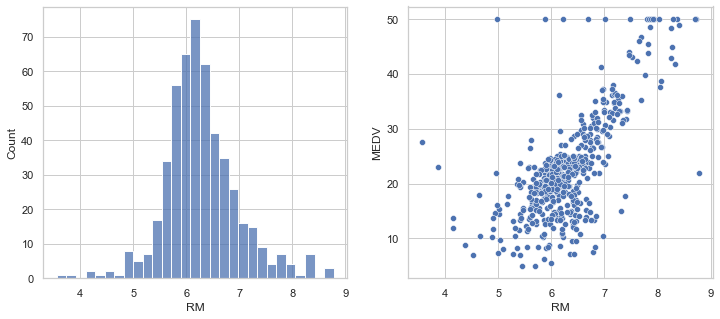

In [143]:
#RM
fig,ax = plt.subplots(figsize=(12,5),nrows=1,ncols=2)
sns.histplot(df_cut_2['RM'],ax=ax[0]);
sns.scatterplot(x=df_cut_2['RM'],y=df_cut_2['MEDV'],ax=ax[1]);

There are random variables, I don't know if there is a solution to fix them

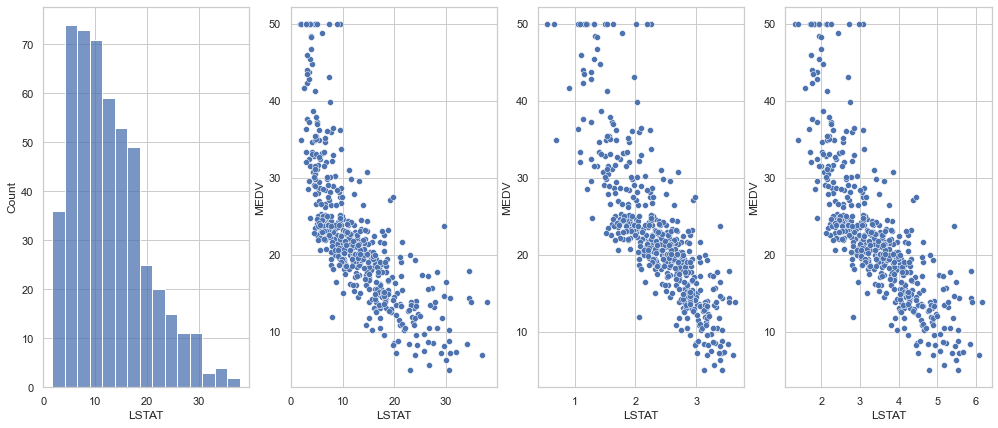

In [144]:
#LSTAT
fig,ax = plt.subplots(figsize=(17,7),nrows=1,ncols=4)
sns.histplot(df_cut_2['LSTAT'],ax=ax[0]);
sns.scatterplot(x=df_cut_2['LSTAT'],y=df_cut_2['MEDV'],ax=ax[1]);
sns.scatterplot(x=np.log(df_cut_2['LSTAT']),y=df_cut_2['MEDV'],ax=ax[2]);
sns.scatterplot(x=np.sqrt(df_cut_2['LSTAT']),y=df_cut_2['MEDV'],ax=ax[3]);

by taking log transformation for LSTAT, the relation between LSTAT and target variable becomes more linear, let's check the correlation:

In [145]:
df_cut_2['LSTAT-log'] = np.log(df_cut_2['LSTAT'])
df_cut_2[['MEDV','LSTAT','LSTAT-log']].corr()

,MEDV,LSTAT,LSTAT-log
MEDV,1.000000,-0.737663,-0.815442
LSTAT,-0.737663,1.000000,0.944031
LSTAT-log,-0.815442,0.944031,1.000000


the correlation improved from (-0.7) to (-0.81), let's remodel and evaluate the score again:

In [146]:
#i will drop LSTAT
col_tran = df_cut_2.columns.drop('LSTAT')
col_tran

Index(['MEDV', 'CRIM', 'INDUS', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B',
       'LSTAT-log'],
      dtype='object')

In [147]:
x_tran, y_tran= m_xy_split(df_cut_2,'MEDV')

In [148]:
x_tran_tr, x_tran_ts, y_tran_tr, y_tran_ts = train_test_split(x_tran,y_tran,train_size=0.8,shuffle=True)

In [149]:
m_mlinear_regression(x_tran_tr,x_tran_ts,y_tran_tr,y_tran_ts)

,index,Model,Type,Scaled,Score
0,12,GradientBoosting,500,No,0.889892
1,24,XGBoost,500,Yes,0.868506
2,11,XGBoost,500,No,0.868431
3,10,Random forest,500,No,0.853293
4,22,Random forest,400,Yes,0.850817
5,7,Random forest,200,No,0.850635
6,19,Random forest,100,Yes,0.849524
7,23,Random forest,500,Yes,0.846832
8,21,Random forest,300,Yes,0.846283
9,8,Random forest,300,No,0.846184


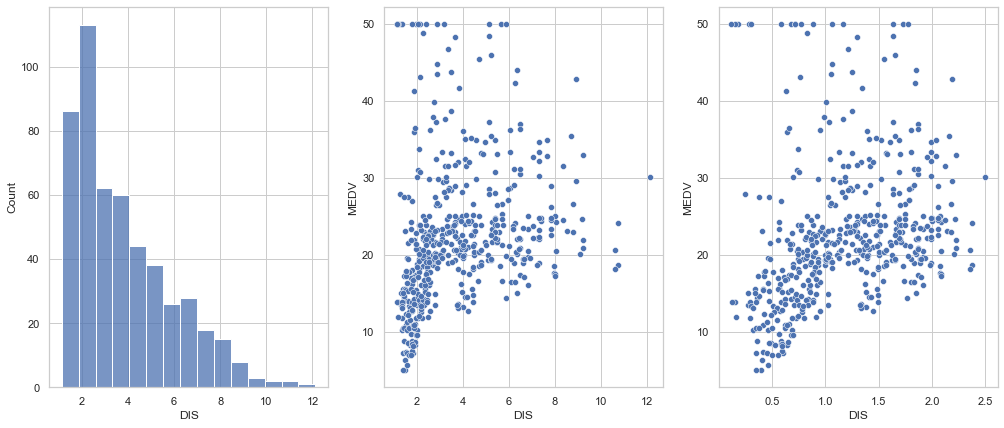

In [150]:
#DIS
fig,ax = plt.subplots(figsize=(17,7),nrows=1,ncols=3)
sns.histplot(df_cut_2['DIS'],ax=ax[0]);
sns.scatterplot(x=df_cut_2['DIS'],y=df_cut_2['MEDV'],ax=ax[1]);
sns.scatterplot(x=np.log(df_cut_2['DIS']),y=df_cut_2['MEDV'],ax=ax[2]);

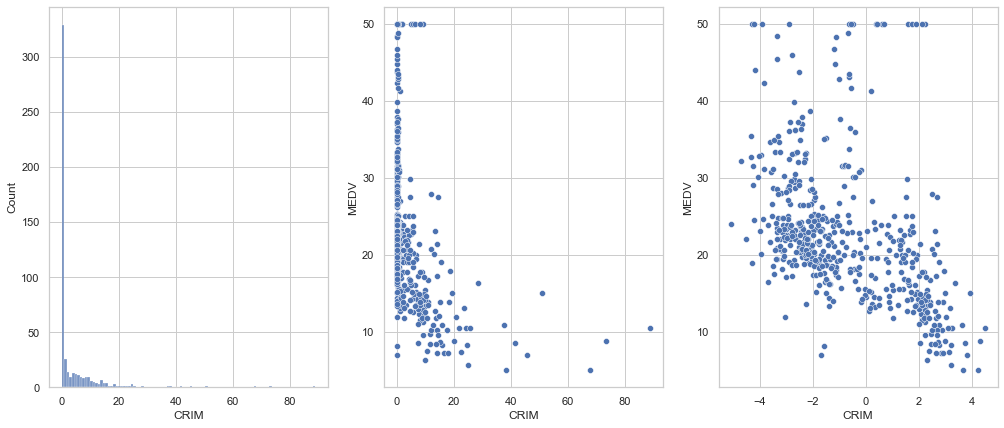

In [151]:
#CRIM
fig,ax = plt.subplots(figsize=(17,7),nrows=1,ncols=3)
sns.histplot(df_cut_2['CRIM'],ax=ax[0]);
sns.scatterplot(x=df_cut_2['CRIM'],y=df_cut_2['MEDV'],ax=ax[1]);
sns.scatterplot(x=np.log(df_cut_2['CRIM']),y=df_cut_2['MEDV'],ax=ax[2]);

It seems that CRIM have some outliers that may affect our model

10.28 % of data will be lost


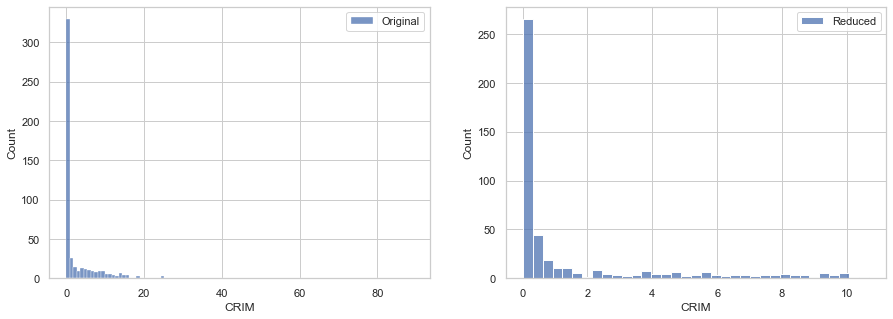

In [152]:
df_cut_3 = m_df_trim(df_cut_2,'CRIM',q_low=0,q_high=0.9);

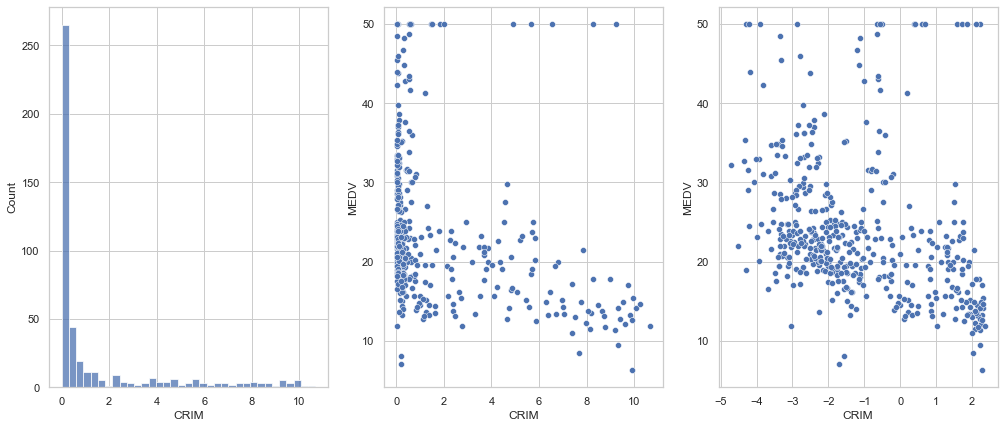

In [153]:
#CRIM
fig,ax = plt.subplots(figsize=(17,7),nrows=1,ncols=3)
sns.histplot(df_cut_3['CRIM'],ax=ax[0]);
sns.scatterplot(x=df_cut_3['CRIM'],y=df_cut_2['MEDV'],ax=ax[1]);
sns.scatterplot(x=np.log(df_cut_3['CRIM']),y=df_cut_2['MEDV'],ax=ax[2]);

In [154]:
df_cut_2[['CRIM','MEDV']].corr()

,CRIM,MEDV
CRIM,1.000000,-0.388305
MEDV,-0.388305,1.000000


In [155]:
df_cut_3[['CRIM','MEDV']].corr()

,CRIM,MEDV
CRIM,1.000000,-0.300041
MEDV,-0.300041,1.000000


cutting 10% of data didn't improve correlation between CRIM and target variable, let's check if we take log of CRIM variable

In [156]:
df_cut_3['CRIM-log'] = np.log(df['CRIM'])

In [157]:
df_cut_3[['MEDV','CRIM','CRIM-log']].corr()

,MEDV,CRIM,CRIM-log
MEDV,1.000000,-0.300041,-0.316979
CRIM,-0.300041,1.000000,0.833965
CRIM-log,-0.316979,0.833965,1.000000


correlation didn't improve alot, an alternative model is to cluster our data into different groups!

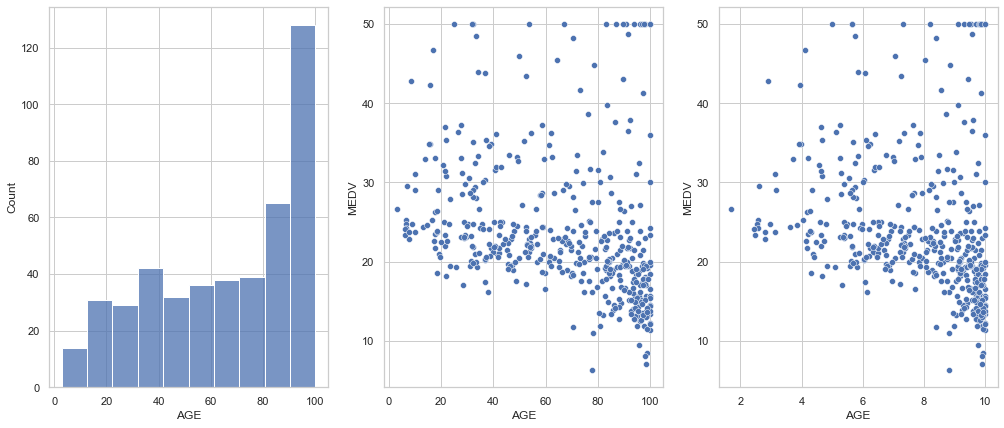

In [158]:
#AGE
fig,ax = plt.subplots(figsize=(17,7),nrows=1,ncols=3)
sns.histplot(df_cut_3['AGE'],ax=ax[0]);
sns.scatterplot(x=df_cut_3['AGE'],y=df_cut_2['MEDV'],ax=ax[1]);
sns.scatterplot(x=np.sqrt(df_cut_3['AGE']),y=df_cut_2['MEDV'],ax=ax[2]);

let's try to fit a model after dropping features [INDUS, AGE, TAX, PTRATIO, B]

In [169]:
col_cut_3 = df_cut_3.columns

In [173]:
col_cut_4 = col_cut_3.drop(['LSTAT','CRIM'])

In [175]:
df_cut_4 = df_cut_3[col_cut_4]
df_cut_4.head()

,MEDV,RM,DIS,LSTAT-log,CRIM-log
1,21.6,6.421,4.9671,2.212660,-3.600502
2,34.7,7.185,4.9671,1.393766,-3.601235
3,33.4,6.998,6.0622,1.078410,-3.430523
4,36.2,7.147,6.0622,1.673351,-2.672924
5,28.7,6.430,6.0622,1.650580,-3.511570


In [176]:
x_cut_4, y_cut_4 = m_xy_split(df_cut_4,'MEDV')

In [179]:
x_cut_4_tr,x_cut_4_ts, y_cut_4_tr,y_cut_4_ts = train_test_split(x_cut_4,y_cut_4,train_size=0.8,shuffle=True)

In [180]:
m_mlinear_regression(x_cut_4_tr,x_cut_4_ts, y_cut_4_tr,y_cut_4_ts)

,index,Model,Type,Scaled,Score
0,23,Random forest,500,Yes,0.875979
1,7,Random forest,200,No,0.875387
2,22,Random forest,400,Yes,0.874992
3,21,Random forest,300,Yes,0.874158
4,10,Random forest,500,No,0.874133
5,8,Random forest,300,No,0.873809
6,6,Random forest,100,No,0.872577
7,20,Random forest,200,Yes,0.872532
8,9,Random forest,400,No,0.870392
9,19,Random forest,100,Yes,0.868992


our model score has dropped after dropping features [INDUS, AGE, TAX, PTRATIO, B], they somehow improve model accuracy, sor our model shall containt the following features: 
* RM
* LSTAT-log
* DIS
* CRIM-log
* ZN
* INDUS
* CHAS
* AGE
* TAX
* PTRATIO
* B<br>
let's remodel from the begining after all information we got

# Final Modeling

In [183]:
df_final = df.copy()

In [184]:
df_final['LSTAT-log'] = np.log(df_final['LSTAT'])
df_final['CRIM-log'] = np.log(df_final['CRIM'])

In [185]:
col_final = df_final.columns
col_final

Index(['MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT', 'LSTAT-log', 'CRIM-log'],
      dtype='object')

In [186]:
col_final_cut = col_final.drop(['LSTAT','CRIM','NOX','RAD'])
df_final_cut = df_final[col_final_cut]

In [187]:
x_final,y_final = m_xy_split(df_final_cut,'MEDV')
xf_tr,xf_ts,yf_tr,yf_ts = train_test_split(x_final,y_final,train_size=0.8,shuffle=True)

In [188]:
m_mlinear_regression(xf_tr,xf_ts,yf_tr,yf_ts)

,index,Model,Type,Scaled,Score
0,12,GradientBoosting,500,No,0.871770
1,19,Random forest,100,Yes,0.864592
2,6,Random forest,100,No,0.860282
3,7,Random forest,200,No,0.860015
4,21,Random forest,300,Yes,0.858463
5,23,Random forest,500,Yes,0.857723
6,20,Random forest,200,Yes,0.855478
7,22,Random forest,400,Yes,0.854687
8,9,Random forest,400,No,0.851884
9,8,Random forest,300,No,0.851771


I will use GradientBoosting with Kfold to make sure of our model accuracy

In [192]:
model = GradientBoostingRegressor()
cv = cross_val_score(estimator=model,X=xf_tr,y=yf_tr,cv=10)

In [199]:
cv.min(), cv.mean(), cv.max()

(0.7464813512877735, 0.8566446463107813, 0.9156864302654802)

we got an accuracy of 85% 